In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# preproccess
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import GenericUnivariateSelect, chi2

# utils
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# ML model
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

In [2]:
# load raw data csv files
"""
attributes: name, n_steps, n_ingredients, steps, ingredients
"""
df_train = pd.read_csv("datasets/recipe_train.csv")
df_test = pd.read_csv("datasets/recipe_test.csv")

In [3]:
def preprocess(df):
    arr_ingr = df['ingredients'].copy().to_numpy()
    arr_steps = df['steps'].copy().to_numpy()
    arr_name = df['name'].copy().to_numpy()
    _RE_COMBINE_WHITESPACE = re.compile(r"\s+")
    ## remove all puntuation
    for i in range(len(arr_steps)):
        arr_steps[i] = re.sub(r'[^\w\s]', '', str(arr_steps[i]))
        arr_steps[i] = _RE_COMBINE_WHITESPACE.sub(" ", arr_steps[i]).strip() + ' '
        arr_ingr[i] = re.sub(r'[^\w\s]', '', str(arr_ingr[i]))
        arr_ingr[i] = _RE_COMBINE_WHITESPACE.sub(" ", arr_ingr[i]).strip() + ' '
        arr_name[i] = re.sub(r'[^\w\s]', '', str(arr_name[i]))
        arr_name[i] = _RE_COMBINE_WHITESPACE.sub(" ", arr_name[i]).strip()
    
    # combined all three features
    X = arr_steps + arr_ingr + arr_name
    return X

Preprocessing:
1) Load the raw data
2) Transform them to 'trainable' data
3) Feature selection

In [4]:
X = preprocess(df_train)
y = df_train['duration_label']

# include both uni-grams and bi-grams 
# exclude stop words
vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2), analyzer='word', stop_words= 'english')
X = vectorizer.fit_transform(X)

print("Shape of X (nrow, ncol):", X.shape)

Shape of X (nrow, ncol): (40000, 580978)


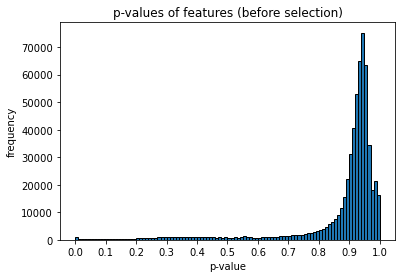

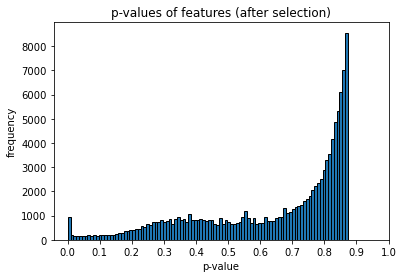

Shape of X_new (nrow, ncol): (40000, 116196)


In [5]:
# plot p-values before feature selection
chi_square, p_values = chi2(X, y)
plt.hist(p_values, edgecolor = 'black', bins=100)
plt.xlabel('p-value')
plt.ylabel('frequency')
plt.title("p-values of features (before selection)")
plt.xticks(np.arange(0,1.1,0.1))
plt.show()

# plot p-values after feature selection
fselect = GenericUnivariateSelect(chi2, mode='percentile', param=20)
X_new = fselect.fit_transform(X, y)

chi_square, p_values = chi2(X_new, y)
plt.hist(p_values, edgecolor = 'black', bins=100)
plt.xlabel('p-value')
plt.ylabel('frequency')
plt.title("p-values of features (after selection)")
plt.xticks(np.arange(0,1.1,0.1))
plt.show()

print("Shape of X_new (nrow, ncol):", X_new.shape)

Hyperparameter tuning

In [19]:
def hyperparameter_tuning(grid, model, X, y):
    
    # define grid search
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, return_train_score=True)
    grid_result = grid_search.fit(X, y)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    train_means = grid_result.cv_results_['mean_train_score']
    test_means = grid_result.cv_results_['mean_test_score']
    test_stdvs = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    train_results = []
    test_results = []
    test_vars = []
    for train_mean, test_mean, test_stdv, param in zip(train_means, test_means, test_stdvs, params):
        if train_mean != 0 and test_mean != 0:
            train_results.append(train_mean)
            test_results.append(test_mean)
            test_vars.append(test_stdv**2)
            #print("%f (%f) with: %r" % (mean, stdev, param))
    return train_results, test_results, test_vars

In [20]:
dc = DummyClassifier()
baseline = sum(cross_validate(dc, X_new, y, cv=5)['test_score'])/5
print("Baseline accuracy:", baseline)

Baseline accuracy: 0.50615


Best: 0.817800 using {'C': 15.0}
Train accuracy: [0.5061500000000001, 0.6739312500000001, 0.7146437499999999, 0.755275, 0.7814562500000001, 0.8353937499999999, 0.86354375, 0.95111875, 0.9809999999999999, 0.9915, 0.9959187500000001]
Test accuracy: [0.50615, 0.669575, 0.709375, 0.745175, 0.7659750000000001, 0.7970250000000001, 0.804875, 0.816175, 0.8175000000000001, 0.8178000000000001, 0.8176249999999999]
Test variance: [2.4999999999972286e-09, 1.1566249999999937e-05, 8.550000000000016e-06, 1.0953749999999842e-05, 1.0496250000000039e-05, 1.1621250000000064e-05, 1.6137500000000003e-05, 2.3884999999999823e-05, 2.220624999999989e-05, 2.3297499999999937e-05, 2.7818749999999836e-05]


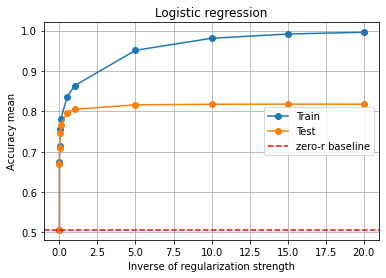

In [22]:
# Logistic Regression
lg = LogisticRegression(max_iter=1000)
c_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0]
grid = dict(C=c_values)
train_results_lg, test_results_lg, test_vars_lg = hyperparameter_tuning(grid, lg, X_new, y)

plt.grid()
plt.plot(c_values, train_results_lg, label='Train', marker='o')
plt.plot(c_values, test_results_lg, label='Test', marker='o')
plt.axhline(y=baseline, color='r', linestyle='--', label='zero-r baseline')
plt.title('Logistic regression')
plt.xlabel('Inverse of regularization strength')
plt.ylabel('Accuracy mean')
plt.legend()
plt.plot()
print("Train accuracy:", train_results_lg)
print("Test accuracy:", test_results_lg)
print("Test variance:", test_vars_lg)

Best: 0.754575 using {'max_depth': 10}
Train accuracy: [0.64685, 0.7337312500000001, 0.80358125, 0.8700187500000001, 0.9228937500000001, 0.95238125, 0.98880625, 0.9985250000000001, 1.0]
Test accuracy: [0.646825, 0.7299500000000001, 0.754575, 0.750725, 0.7400500000000001, 0.733475, 0.7224, 0.7169, 0.7179]
Test variance: [3.24037500000001e-05, 3.1722499999999824e-05, 1.857874999999988e-05, 1.6358749999999996e-05, 1.606625000000001e-05, 3.069624999999986e-05, 8.865000000000009e-06, 9.696250000000028e-06, 5.8774999999999806e-06]


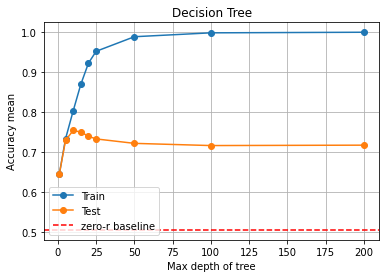

In [23]:
# Decision Tree
dt = DecisionTreeClassifier()
max_depths = [1, 5, 10, 15, 20, 25, 50, 100, 200]
grid = dict(max_depth=max_depths)
train_results_dt, test_results_dt, test_vars_dt = hyperparameter_tuning(grid, dt, X_new, y)

plt.grid()
plt.plot(max_depths, train_results_dt, label='Train', marker='o')
plt.plot(max_depths, test_results_dt, label='Test', marker='o')
plt.axhline(y=baseline, color='r', linestyle='--', label='zero-r baseline')
plt.title('Decision Tree')
plt.xlabel('Max depth of tree')
plt.ylabel('Accuracy mean')
plt.legend()
plt.plot()
print("Train accuracy:", train_results_dt)
print("Test accuracy:", test_results_dt)
print("Test variance:", test_vars_dt)

Best: 0.820125 using {'C': 1.0}
Train accuracy: [0.65559375, 0.73798125, 0.76494375, 0.8157499999999999, 0.8397, 0.9243062500000001, 0.9615625, 0.99899375, 0.9999812499999999, 1.0, 1.0]
Test accuracy: [0.6516, 0.73105, 0.754475, 0.790025, 0.7994000000000001, 0.816575, 0.820125, 0.817175, 0.8130749999999999, 0.8107749999999999, 0.809525]
Test variance: [1.0933750000000034e-05, 1.2041250000000037e-05, 6.483749999999943e-06, 1.1427499999999968e-05, 1.6521249999999885e-05, 1.9759999999999963e-05, 2.654375000000026e-05, 1.5291249999999973e-05, 2.0647499999999873e-05, 2.5471250000000286e-05, 2.6171250000000042e-05]


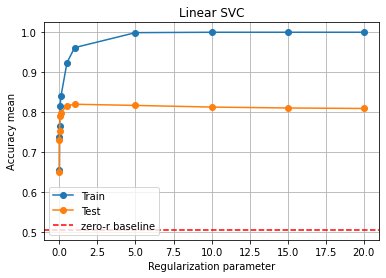

In [21]:
# Linear SVM
lsvm = LinearSVC()
c_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0]
grid = dict(C = c_values)
train_results_lsvm, test_results_lsvm, test_vars_lsvm = hyperparameter_tuning(grid, lsvm, X_new, y)

plt.grid()
plt.plot(c_values, train_results_lsvm, label='Train', marker='o')
plt.plot(c_values, test_results_lsvm, label='Test', marker='o')
plt.axhline(y=baseline, color='r', linestyle='--', label='zero-r baseline')
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy mean')
plt.title('Linear SVC')
plt.legend()
plt.plot()
print("Train accuracy:", train_results_lsvm)
print("Test accuracy:", test_results_lsvm)
print("Test variance:", test_vars_lsvm)

Evaluation: Confusion matrix

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=42)

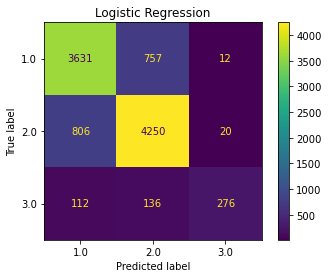

In [28]:
lg = LogisticRegression(max_iter=1000, C=15.0)
lg.fit(X_train, y_train)
plot_confusion_matrix(lg, X_test, y_test)
plt.title('Logistic Regression')
plt.show()

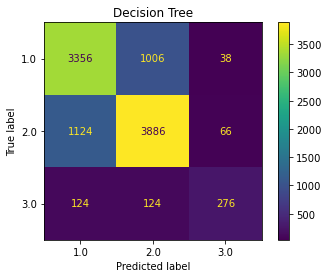

In [29]:
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train, y_train)
plot_confusion_matrix(dt, X_test, y_test)
plt.title('Decision Tree')
plt.show()

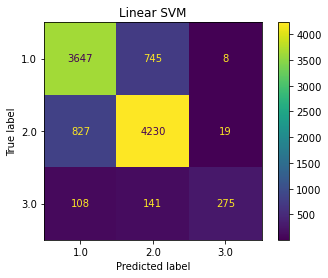

In [30]:
lsvm = LinearSVC(C=1.0)
lsvm.fit(X_train, y_train)
plot_confusion_matrix(lsvm, X_test, y_test)
plt.title('Linear SVM')
plt.show()